In [2]:
library(repr)

In [3]:
options(repr.plot.width=14, repr.plot.height=14)

In [4]:
library(tidyverse)
library(DESeq2)
library(pheatmap)
library(EnhancedVolcano)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The follow

In [5]:
library(naturalsort)

## Promoter region ATAC read count

count files: `/c/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3/calc_TF_promoters_counts.sh/ATAC*.PE.mapq.bam.counts`

In [6]:
setwd("/c/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3")

In [7]:
#120 hit list
hitlist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/Hitlist_20191230.csv', header = T, stringsAsFactors = F) %>% pull(hgnc_symbol)
#TF list
tflist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/TFlist_20191230.csv', stringsAsFactors = F) %>% select(hgnc_symbol)

In [8]:
promoter.count.files <- list.files('.', "PE.mapq.bam.counts") %>% naturalsort

sample <- map_chr(promoter.count.files, ~ str_remove(.x, ".PE.mapq.bam.counts"))

sample <- factor(sample, levels = sample)

promoter.counts <- map2(promoter.count.files, sample,
                           ~ read.table(.x, header = F, sep = "\t", stringsAsFactors = F,
                                        col.names = c("chr","start", "end", "gene", "score", "strand", "counts")) %>%
                             add_column("sample"=.y) %>%
                               select(gene, counts, sample) %>%
                               group_by(gene, sample) %>%
                               summarise_all(sum))

In [9]:
# get a vector of ATAC1 - ATAC12 library size (total read counts)
atac_library_totals <- read.table("PE.mapq.bam.library.tally", header = F, sep = " ", stringsAsFactors = F)[1:12,]
atac_library_totals <- data.frame("sample" = map_chr(atac_library_totals$V1, ~ str_extract(.x, "ATAC[0-9]+")), 
                                        "totalreads" = atac_library_totals$V5, stringsAsFactors = F)
atac_library_totals <- left_join(as.data.frame(sample), atac_library_totals)$totalreads

Joining, by = "sample"
Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”


In [10]:
# get count matrix for TFs only
dds1 <- map(promoter.counts, ~ left_join(tflist, .x, by = c("hgnc_symbol"="gene"))$counts)
dds1 <- do.call(cbind, dds1) %>% as.data.frame
names(dds1) <- sample
dds1 <- mutate_all(dds1, ~ replace(., is.na(.x), 0)) # replace na

In [11]:
# add row names
rownames(dds1) <- tflist$hgnc_symbol

In [12]:
sample_lookup <- tribble(~ sample, ~ time, ~ rep, 
                        "ATAC1", "ES", "1",
                        "ATAC2", "ES", "2",
                        "ATAC3", "H1", "1",
                        "ATAC4", "H1", "2",
                        "ATAC5", "H4", "1",
                        "ATAC6", "H4", "2",
                        "ATAC7", "H16", "1",
                        "ATAC8", "H16", "2",
                        "ATAC9", "D1", "1",
                        "ATAC10", "D1", "2",
                        "ATAC11", "D4", "1",
                        "ATAC12", "D4", "2",)

In [13]:
sample_lookup <- mutate_at(sample_lookup, "sample", ~ factor(.x, levels = sample)) %>%
                    mutate_at("time", ~ factor(.x, levels = c("ES", "H1","H4","H16","D1","D4")))

In [14]:
sample_lookup[, 1:2] %>% t

sample,ATAC1,ATAC2,ATAC3,ATAC4,ATAC5,ATAC6,ATAC7,ATAC8,ATAC9,ATAC10,ATAC11,ATAC12
time,ES,ES,H1,H1,H4,H4,H16,H16,D1,D1,D4,D4


In [15]:
dds2 <- DESeqDataSetFromMatrix(countData = dds1, colData = sample_lookup, design = ~ time)

converting counts to integer mode



In [16]:
dds2

class: DESeqDataSet 
dim: 1889 12 
metadata(1): version
assays(1): counts
rownames(1889): ABL1 ABT1 ... NSD2 NSD3
rowData names(0):
colnames(12): ATAC1 ATAC2 ... ATAC11 ATAC12
colData names(3): sample time rep

In [17]:
keep <- rowSums(counts(dds2)) >= 10

In [18]:
dds2 <- dds2[keep,]

In [19]:
dds2 <- DESeq(dds2)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [20]:
dds2

class: DESeqDataSet 
dim: 1877 12 
metadata(1): version
assays(4): counts mu H cooks
rownames(1877): ABL1 ABT1 ... NSD2 NSD3
rowData names(38): baseMean baseVar ... deviance maxCooks
colnames(12): ATAC1 ATAC2 ... ATAC11 ATAC12
colData names(4): sample time rep sizeFactor

In [21]:
resultsNames(dds2)

[1] "Intercept"      "time_H1_vs_ES"  "time_H4_vs_ES"  "time_H16_vs_ES"
[5] "time_D1_vs_ES"  "time_D4_vs_ES"

In [22]:
H16_vs_ES <- results(dds2, contrast = c("time", "H16", "ES")) %>%
                    as.data.frame %>% 
                    rownames_to_column("gene")

In [23]:
H16_vs_ES_up.genes <- filter(H16_vs_ES, padj < .05 & log2FoldChange > log2(1.5) )
H16_vs_ES_dn.genes <- filter(H16_vs_ES, padj < .05 & log2FoldChange < -log2(1.5) )

In [24]:
filter(H16_vs_ES, padj < .05 & abs(log2FoldChange) > log2(1.5) & log2FoldChange < 0)

gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AEBP1,298.1202,-0.7073331,0.1561928,-4.528591,5.937839e-06,0.0018484273
DEAF1,407.4916,-0.5862750,0.1701881,-3.444864,5.713458e-04,0.0202099590
DMRTB1,141.9836,-0.8121528,0.2370991,-3.425372,6.139573e-04,0.0205728072
EVX1,237.2748,-0.7242888,0.1800530,-4.022643,5.754881e-05,0.0059564126
FOXJ1,354.5074,-0.6399889,0.1455749,-4.396285,1.101191e-05,0.0024831857
GATA5,324.2037,-0.5959376,0.1557540,-3.826147,1.301645e-04,0.0086917705
GSX2,223.2274,-0.7164292,0.1864810,-3.841835,1.221179e-04,0.0084731024
IKBKG,135.6607,-0.7781222,0.2329633,-3.340107,8.374609e-04,0.0260479231
LHX3,265.5978,-0.5895681,0.1590281,-3.707319,2.094650e-04,0.0118085894


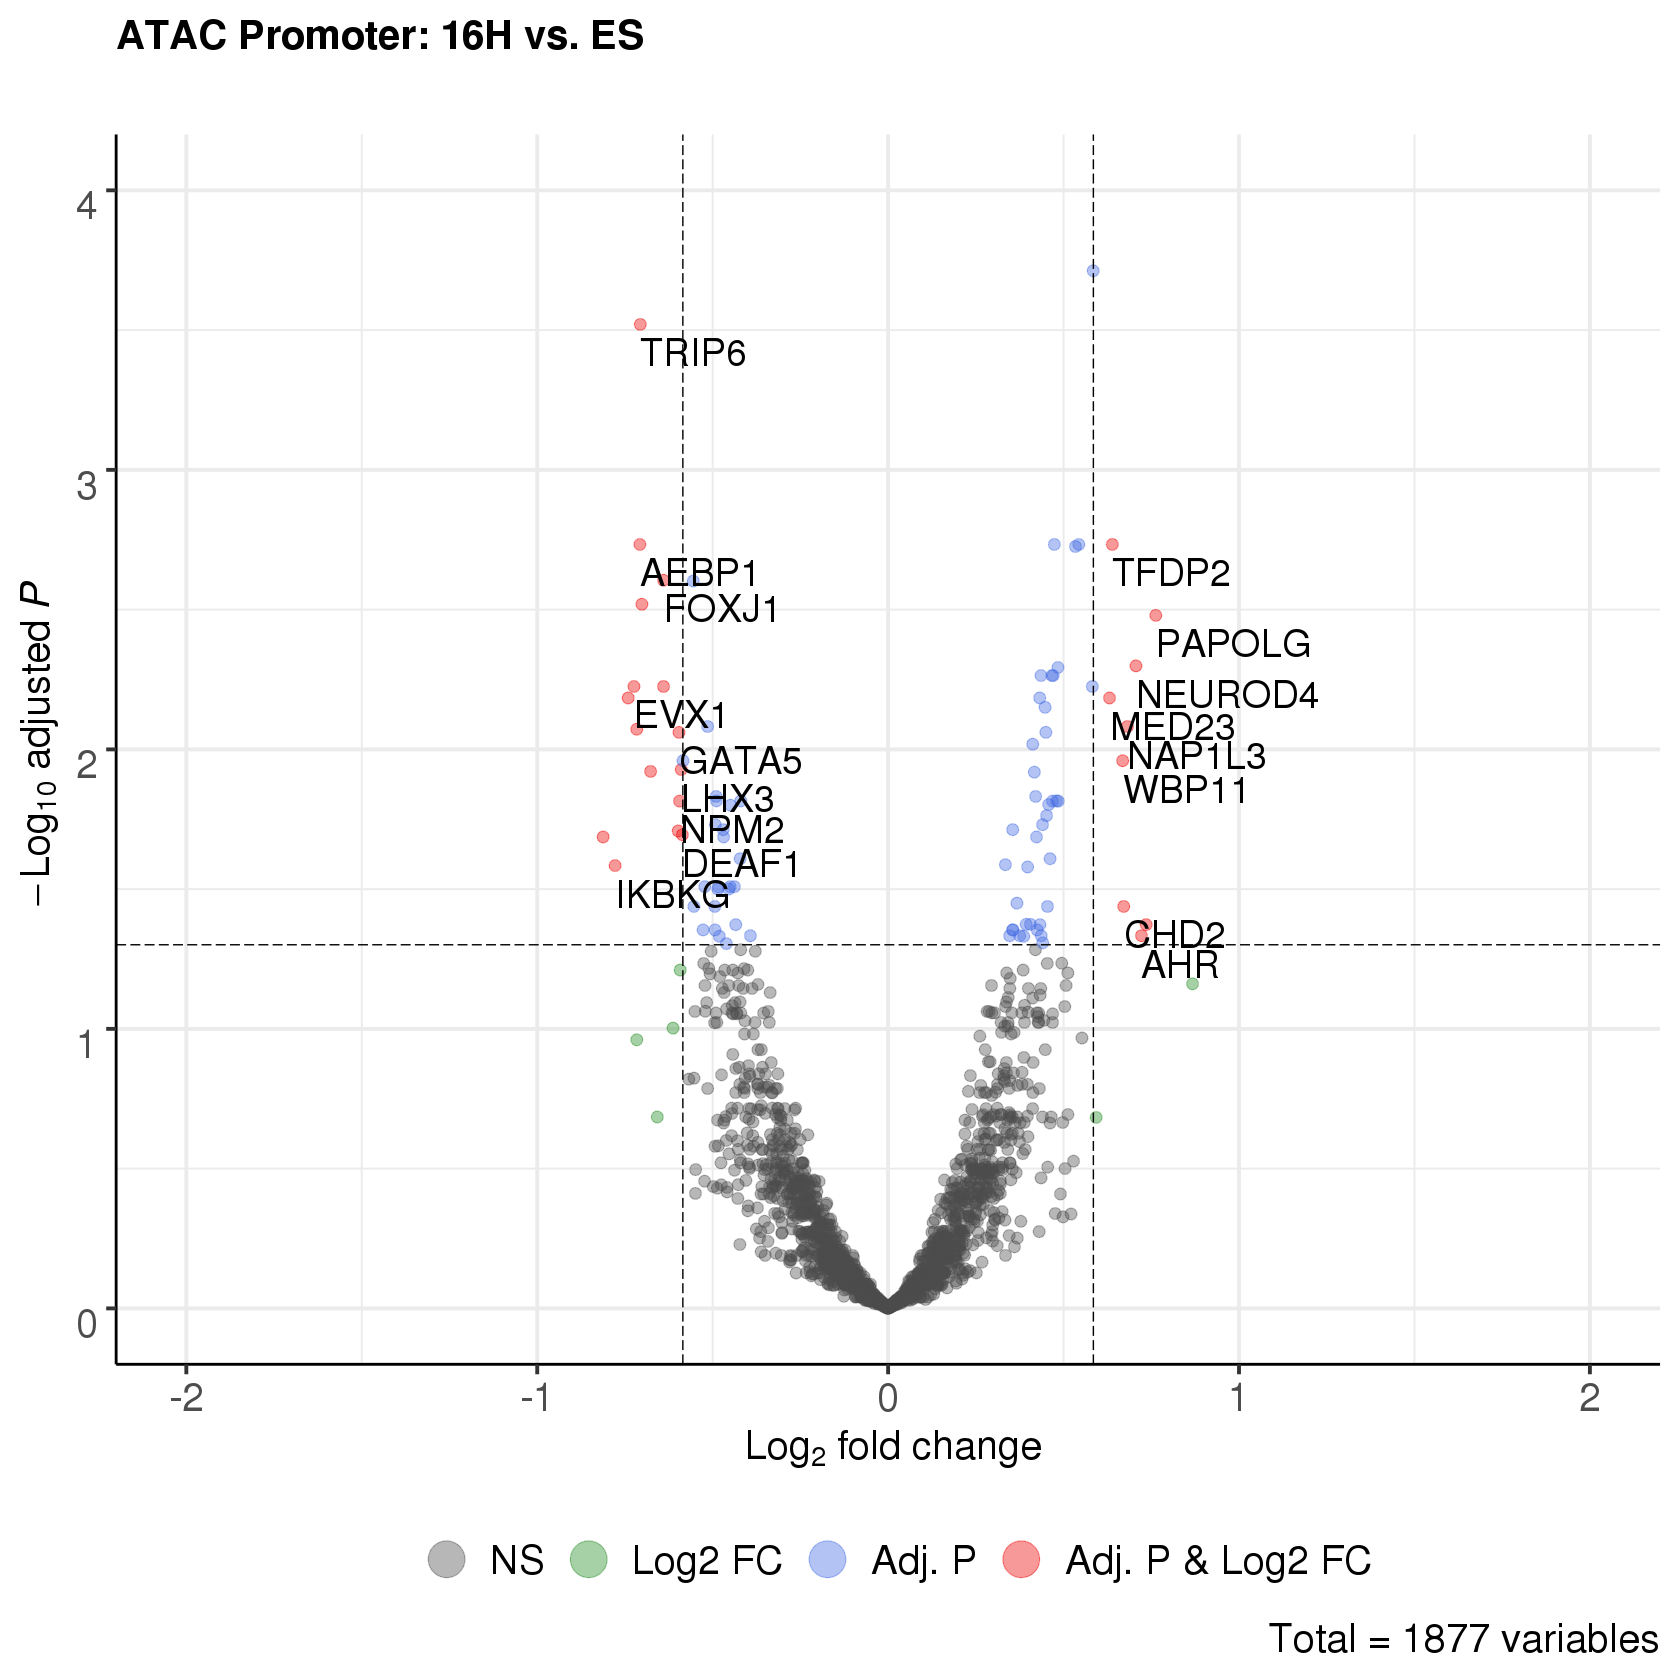

In [45]:
H16_vs_ES %>%
    EnhancedVolcano(lab = H16_vs_ES$gene, x = 'log2FoldChange', y = 'padj', 
                    xlab = bquote(~Log[2]~ 'fold change'), 
                    ylab= bquote(~-Log[10]~adjusted~italic(P)),
                    xlim=c(-2,2),
                    ylim=c(0,4),
                    legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),
                    legendPosition='bottom', legendLabSize = 24, 
                    legendIconSize = 10.0, 
                    title = "ATAC Promoter: 16H vs. ES", 
                    subtitle="", 
                    pCutoff = 0.05, 
                    FCcutoff = log2(1.5),
                    transcriptPointSize = 3, 
                    transcriptLabSize = 8, 
                    colAlpha = .4,
                    axisLabSize = 24,
                    titleLabSize = 24,
                    subtitleLabSize = 24,
                    captionLabSize = 24)
    

In [37]:
D1_vs_ES <- results(dds2, contrast = c("time", "D1", "ES")) %>%
                    as.data.frame %>% 
                    rownames_to_column("gene")

In [38]:
D1_vs_ES_up.genes <- filter(D1_vs_ES, padj < .05 & log2FoldChange > log2(1.5) )
D1_vs_ES_dn.genes <- filter(D1_vs_ES, padj < .05 & log2FoldChange < -log2(1.5) )

In [39]:
D1_vs_ES_up.genes$gene %>% intersect(., hitlist)

[1] "E2F1"

In [40]:
filter(D1_vs_ES, padj < .05 & log2FoldChange > log2(1.5))

gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DHX38,464.5509,0.6748825,0.1307806,5.160419,2.463983e-07,5.068764e-05
E2F1,476.2238,0.5950388,0.1289495,4.614511,3.940221e-06,3.861568e-04
HES6,600.5651,0.7334610,0.1148839,6.384370,1.721049e-10,1.239155e-07
HNRNPR,456.4024,0.5992865,0.1204300,4.976221,6.483765e-07,1.037402e-04
MED23,343.6365,0.7024948,0.1547107,4.540699,5.606795e-06,4.814962e-04
NAP1L3,312.8679,0.7391713,0.1719771,4.298080,1.722843e-05,9.923575e-04
PAPOLG,236.6374,0.7495030,0.1735098,4.319658,1.562715e-05,9.557437e-04
SERTAD2,716.5667,0.5999305,0.1140834,5.258703,1.450746e-07,4.178149e-05
SMARCAD1,233.2332,0.7278831,0.1686698,4.315433,1.592906e-05,9.557437e-04


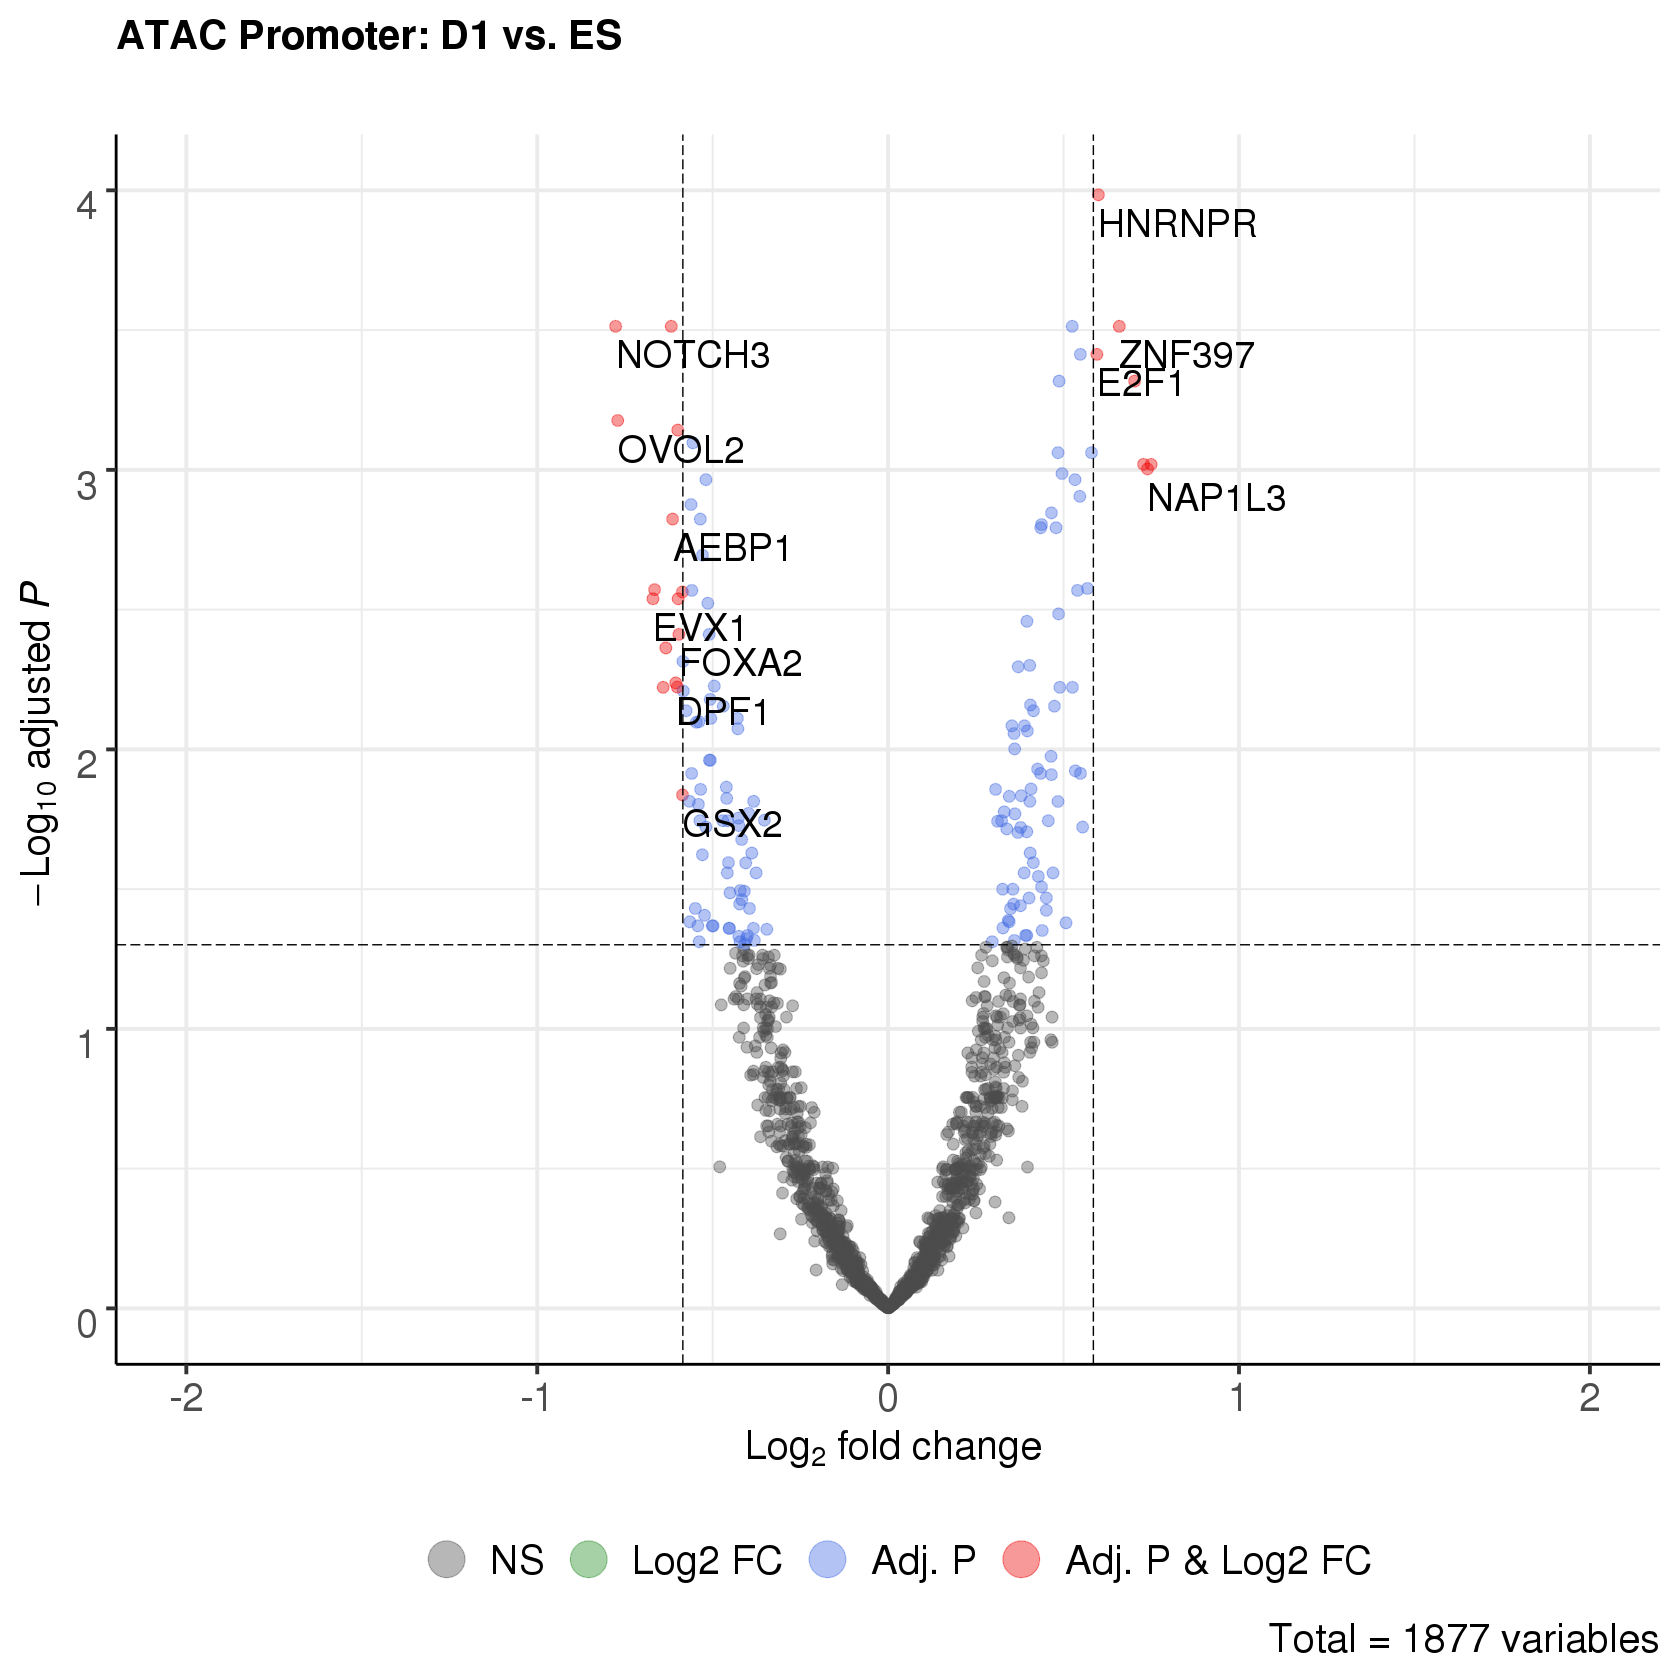

In [46]:
D1_vs_ES %>%
    EnhancedVolcano(lab = D1_vs_ES$gene, x = 'log2FoldChange', y = 'padj', 
                    xlab = bquote(~Log[2]~ 'fold change'), 
                    ylab= bquote(~-Log[10]~adjusted~italic(P)),
                    xlim=c(-2,2),
                    ylim=c(0,4),
                    legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),
                    legendPosition='bottom', legendLabSize = 24, 
                    legendIconSize = 10, 
                    title = "ATAC Promoter: D1 vs. ES", 
                    subtitle="", 
                    pCutoff = 0.05, 
                    FCcutoff = log2(1.5),
                    transcriptPointSize = 3, 
                    transcriptLabSize = 8, 
                    colAlpha = .4,
                    axisLabSize = 24,
                    titleLabSize = 24,
                    subtitleLabSize = 24,
                    captionLabSize = 24)
    

In [47]:
D4_vs_ES <- results(dds2, contrast = c("time", "D4", "ES")) %>%
                    as.data.frame %>% 
                    rownames_to_column("gene")

In [48]:
D4_vs_ES_up.genes <- filter(D4_vs_ES, padj < .05 & log2FoldChange > log2(1.5) )
D4_vs_ES_dn.genes <- filter(D4_vs_ES, padj < .05 & log2FoldChange < -log2(1.5) )

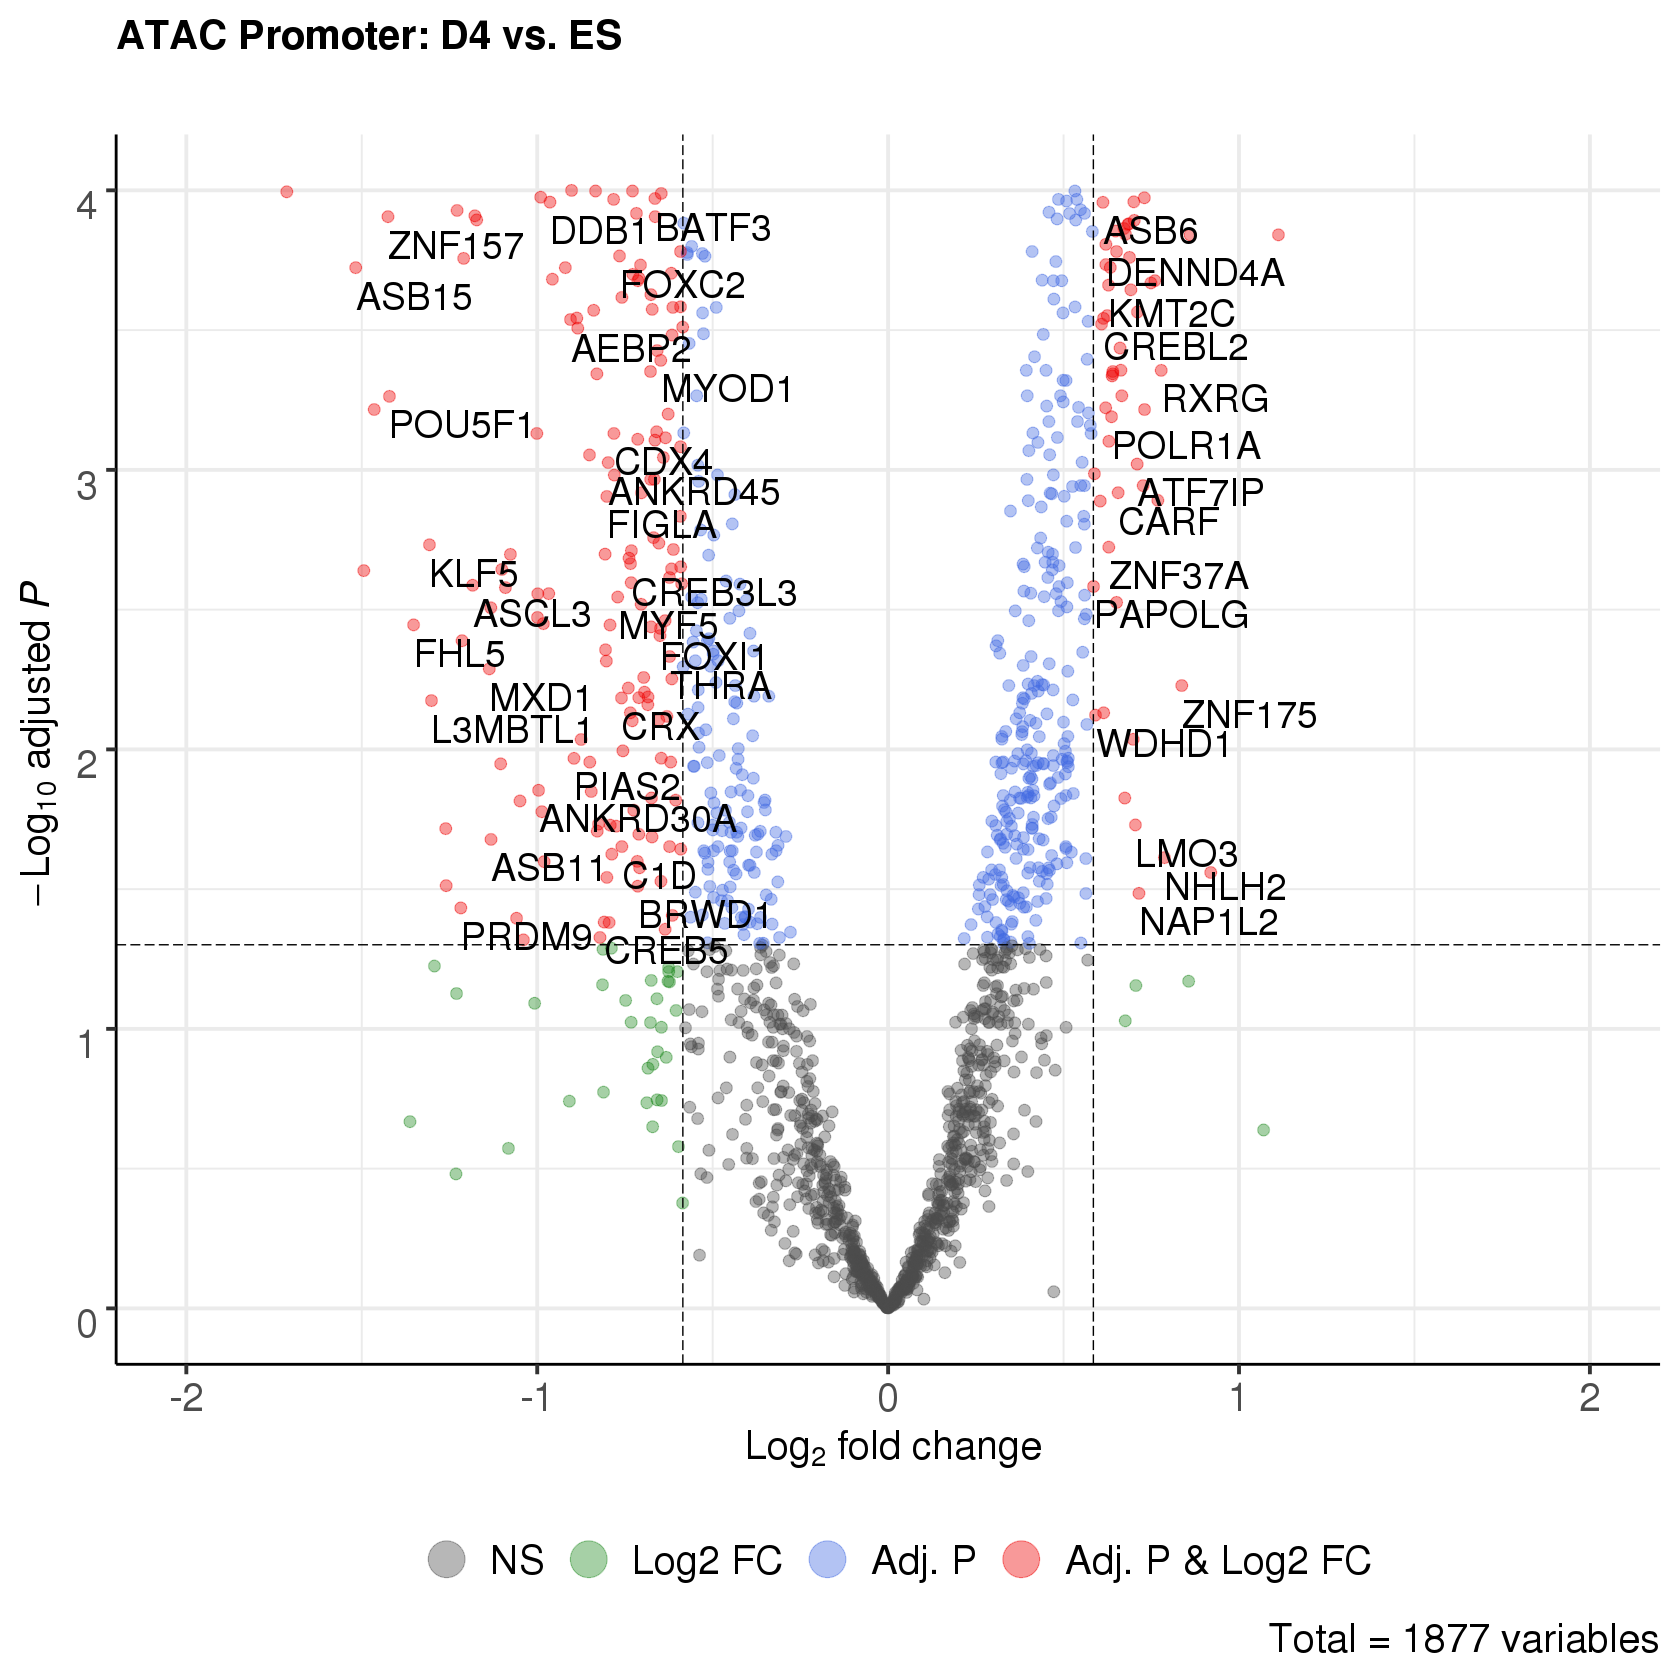

In [50]:
D4_vs_ES %>%
    EnhancedVolcano(lab = D4_vs_ES$gene, x = 'log2FoldChange', y = 'padj', 
                    xlab = bquote(~Log[2]~ 'fold change'), 
                    ylab= bquote(~-Log[10]~adjusted~italic(P)),
                    xlim=c(-2,2),
                    ylim=c(0,4),
                    legend=c('NS','Log2 FC','Adj. P', 'Adj. P & Log2 FC'),
                    legendPosition='bottom', legendLabSize = 24, 
                    legendIconSize = 10.0, 
                    title = "ATAC Promoter: D4 vs. ES", 
                    subtitle="", 
                    pCutoff = 0.05, 
                    FCcutoff = log2(1.5),
                    transcriptPointSize = 3, 
                    transcriptLabSize = 8, 
                    colAlpha = .4,
                    axisLabSize = 24,
                    titleLabSize = 24,
                    subtitleLabSize = 24,
                    captionLabSize = 24)
    

#### number of TFs increasing or decreasingly accessible

time |  up   |   down
---- | ------| ------
H16  | 9    |     16 |
D1   |  11  |     18
D4   | 183 | 368

In [51]:
num.diff.tf <- tribble(~ time, ~ up, ~ down,
                        "H16", 9, 16,
                        "D1", 11, 18,
                        "D4", 183, 368) %>%
                pivot_longer(up:down, names_to=c("direction"), values_to = "number_of_TFs") %>%
                mutate_at("time", ~ factor(.x, levels=c("H16", "D1", "D4")))

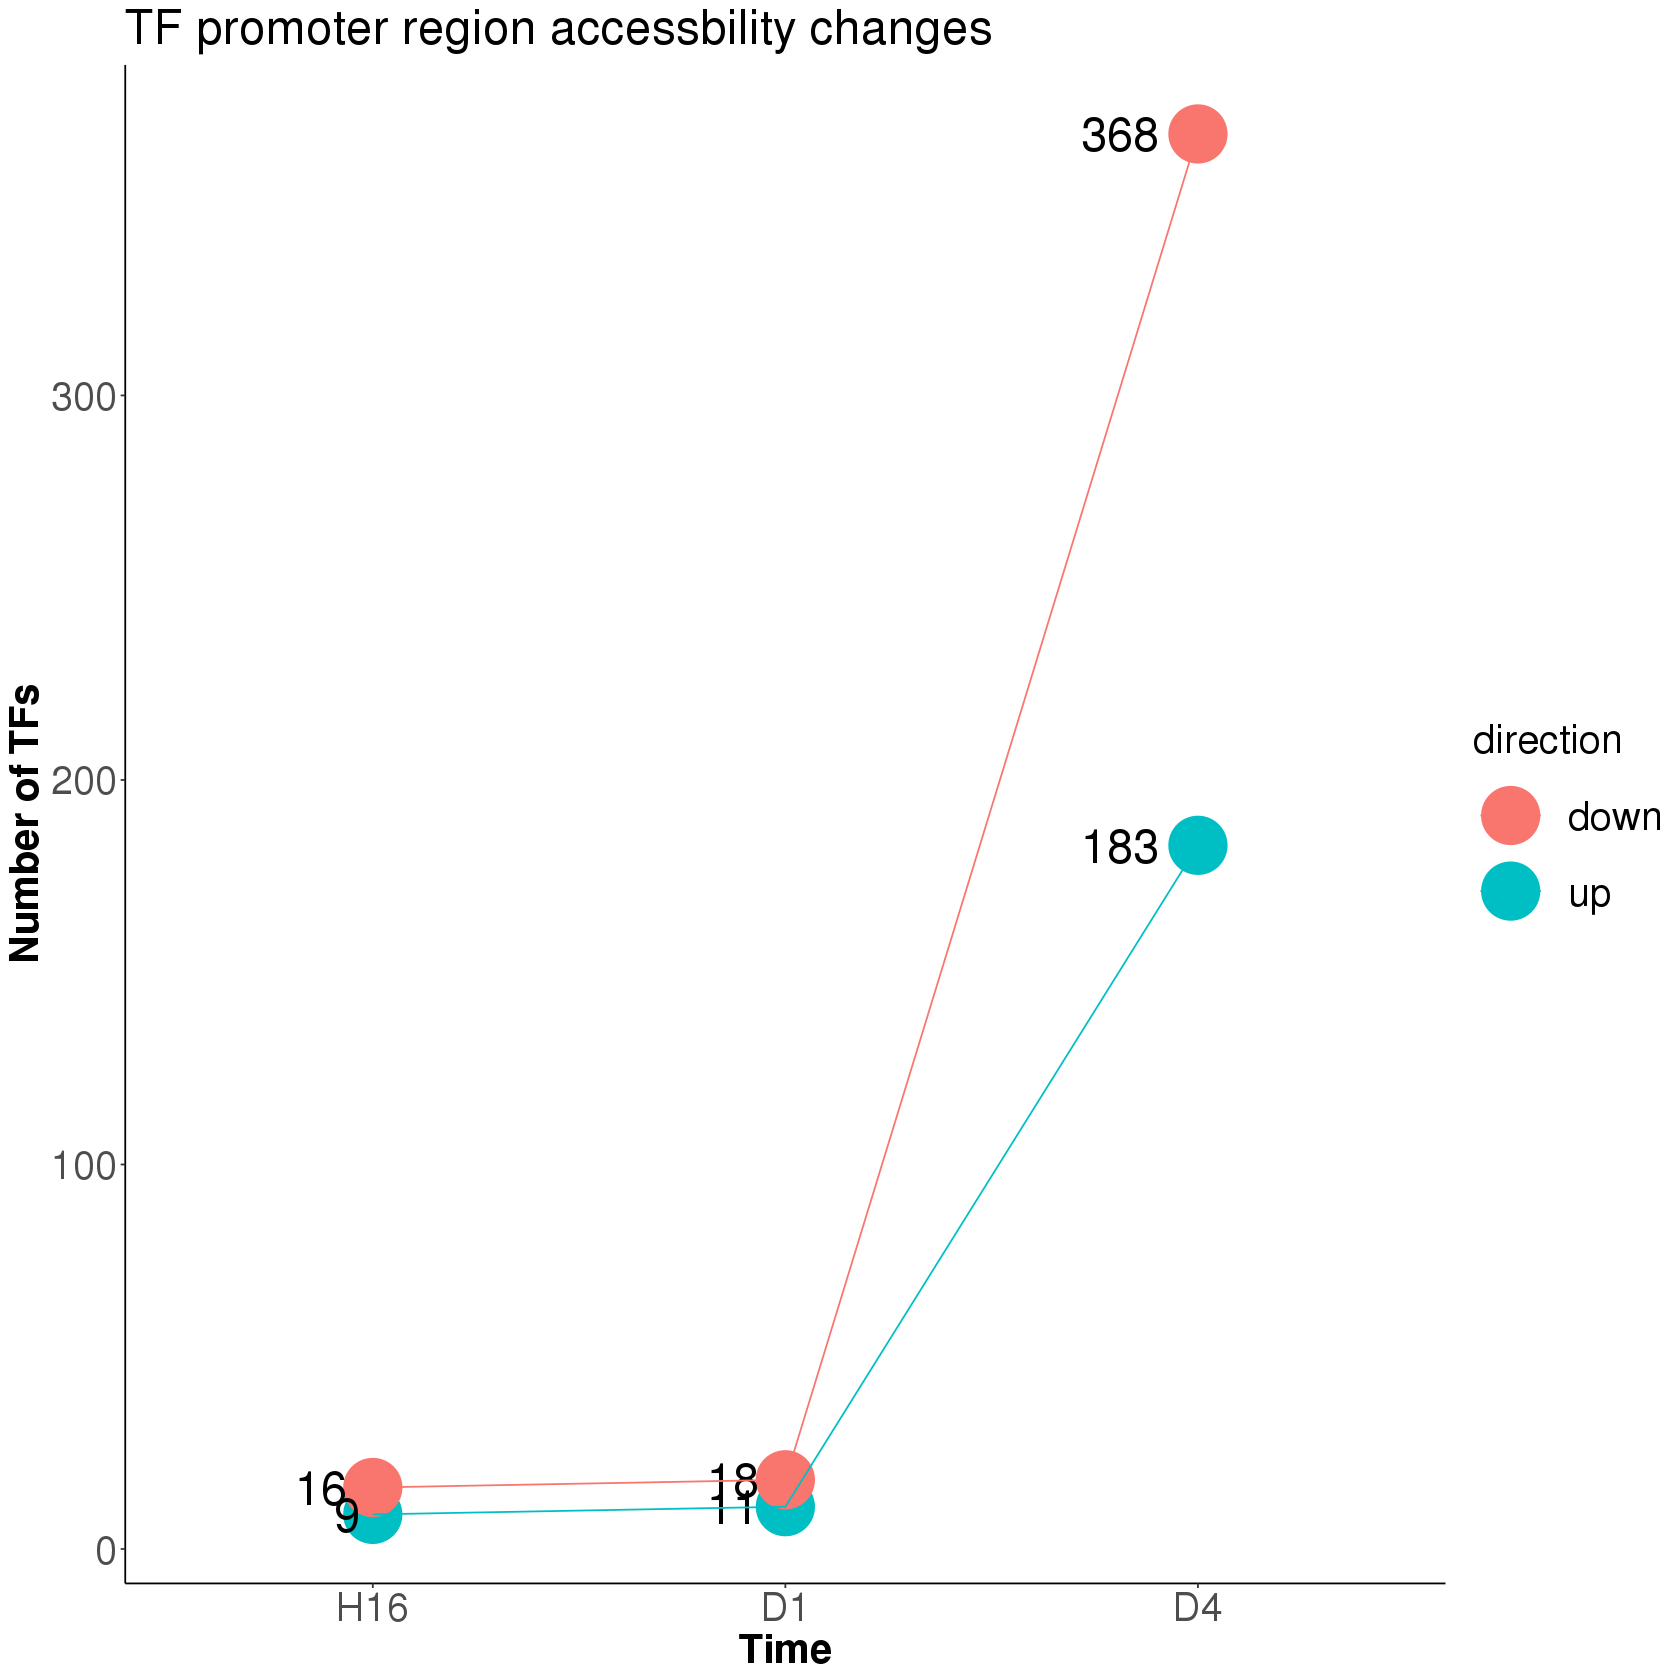

In [68]:
ggplot(num.diff.tf) + geom_point(aes(x=time, y=number_of_TFs, color=direction), size = 16) +
    geom_text(aes(x=time, y=number_of_TFs, label=number_of_TFs), hjust=1.5,size=10) +
    geom_line(aes(x=time, y=number_of_TFs, group=direction, color=direction)) + 
    xlab(label = "Time") + ylab(label = "Number of TFs") +
    labs(title = "TF promoter region accessbility changes") +
    theme_classic() +
    theme(axis.text=element_text(size=24), axis.title=element_text(size=24,face="bold"), 
          legend.text=element_text(size=24),legend.title=element_text(size=24), title=element_text(size=24))
   
    

In [653]:
# H16
filter(H16_vs_ES, padj < .05 & abs(log2FoldChange) > log2(1.5) & gene %in% hitlist) %>% select(gene,log2FoldChange, padj)

gene,log2FoldChange,padj
<chr>,<dbl>,<dbl>
AHR,0.7220826,0.04640378


In [652]:
# D1
filter(D1_vs_ES, padj < .05 & abs(log2FoldChange) > log2(1.5) & gene %in% hitlist) %>% select(gene,log2FoldChange, padj)

gene,log2FoldChange,padj
<chr>,<dbl>,<dbl>
E2F1,0.5950388,0.0003861568
POU2F3,-0.6655255,0.0026821225


In [651]:
# D4
filter(D4_vs_ES, padj < .05 & abs(log2FoldChange) > log2(1.5) & gene %in% hitlist) %>% 
    select(gene,log2FoldChange, padj) %>%
    top_n(25, "padj") %>% 
    arrange(desc(log2FoldChange)) 

gene,log2FoldChange,padj
<chr>,<dbl>,<dbl>
ZNF510,1.1123290,1.442793e-04
MPHOSPH8,1.0309036,3.727085e-10
E2F1,0.8660794,3.868046e-10
ZNF92,0.8478692,7.742201e-07
POU3F2,0.8444061,3.150799e-14
ZNF107,0.8370762,2.456842e-06
TBPL1,0.7663553,3.737350e-07
ZBTB18,0.7517927,1.787634e-07
JUND,0.7508927,3.964445e-09


In [452]:
D4_vs_ES.genes %>% filter(gene %in% "ZBTB18")

gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,541.8755,0.7517927,0.1330494,5.650479,1.600014e-08,1.787634e-07


In [463]:
library(VennDiagram)

Loading required package: grid

Loading required package: futile.logger



In [476]:
flatui = c("#9b59b6", "#3498db", "#004F99", "#250352", "#95a5a6", "#e74c3c", "#ECE59A", "#34495e", "#2ecc71", "#5B9E00", "#A71812")

In [624]:
validated.hits <- c("ZBTB18", "ZZZ3", "ARID1B", "ZNF311")

In [626]:
intersect(validated.hits, open.hit.tf)

[1] "ZBTB18"

In [657]:
vp <- venn.diagram(list("H16"=H16_vs_ES_up.genes$gene, "D1"=D1_vs_ES_up.genes$gene, "D4"=D4_vs_ES_up.genes$gene, "HitTF"=hitlist), 
                   filename=NULL,
                    # Circles
                    lwd = 2,
                    lty = 'blank',
                    fill = flatui[c(1,3,5,9)],
                    main = "Chromatin Accessibility increasing TFs",
                    main.fontfamily = "sans",
                    main.cex = 3,

                    # Numbers
                    cex = 2,
                    fontface = "bold",
                    fontfamily = "sans",

                    # Set names
                    cat.cex = 2,
                    cat.fontface = "bold",
                    cat.default.pos = "outer",
                    #cat.pos = c(-27, 27, 135),
                    #cat.dist = c(0.055, 0.055, .055),
                    cat.fontfamily = "sans")

In [658]:
intersect(H16_vs_ES_up.genes$gene, D1_vs_ES_up.genes$gene) %>% intersect(D4_vs_ES_up.genes$gene)

[1] "NAP1L3" "PAPOLG"

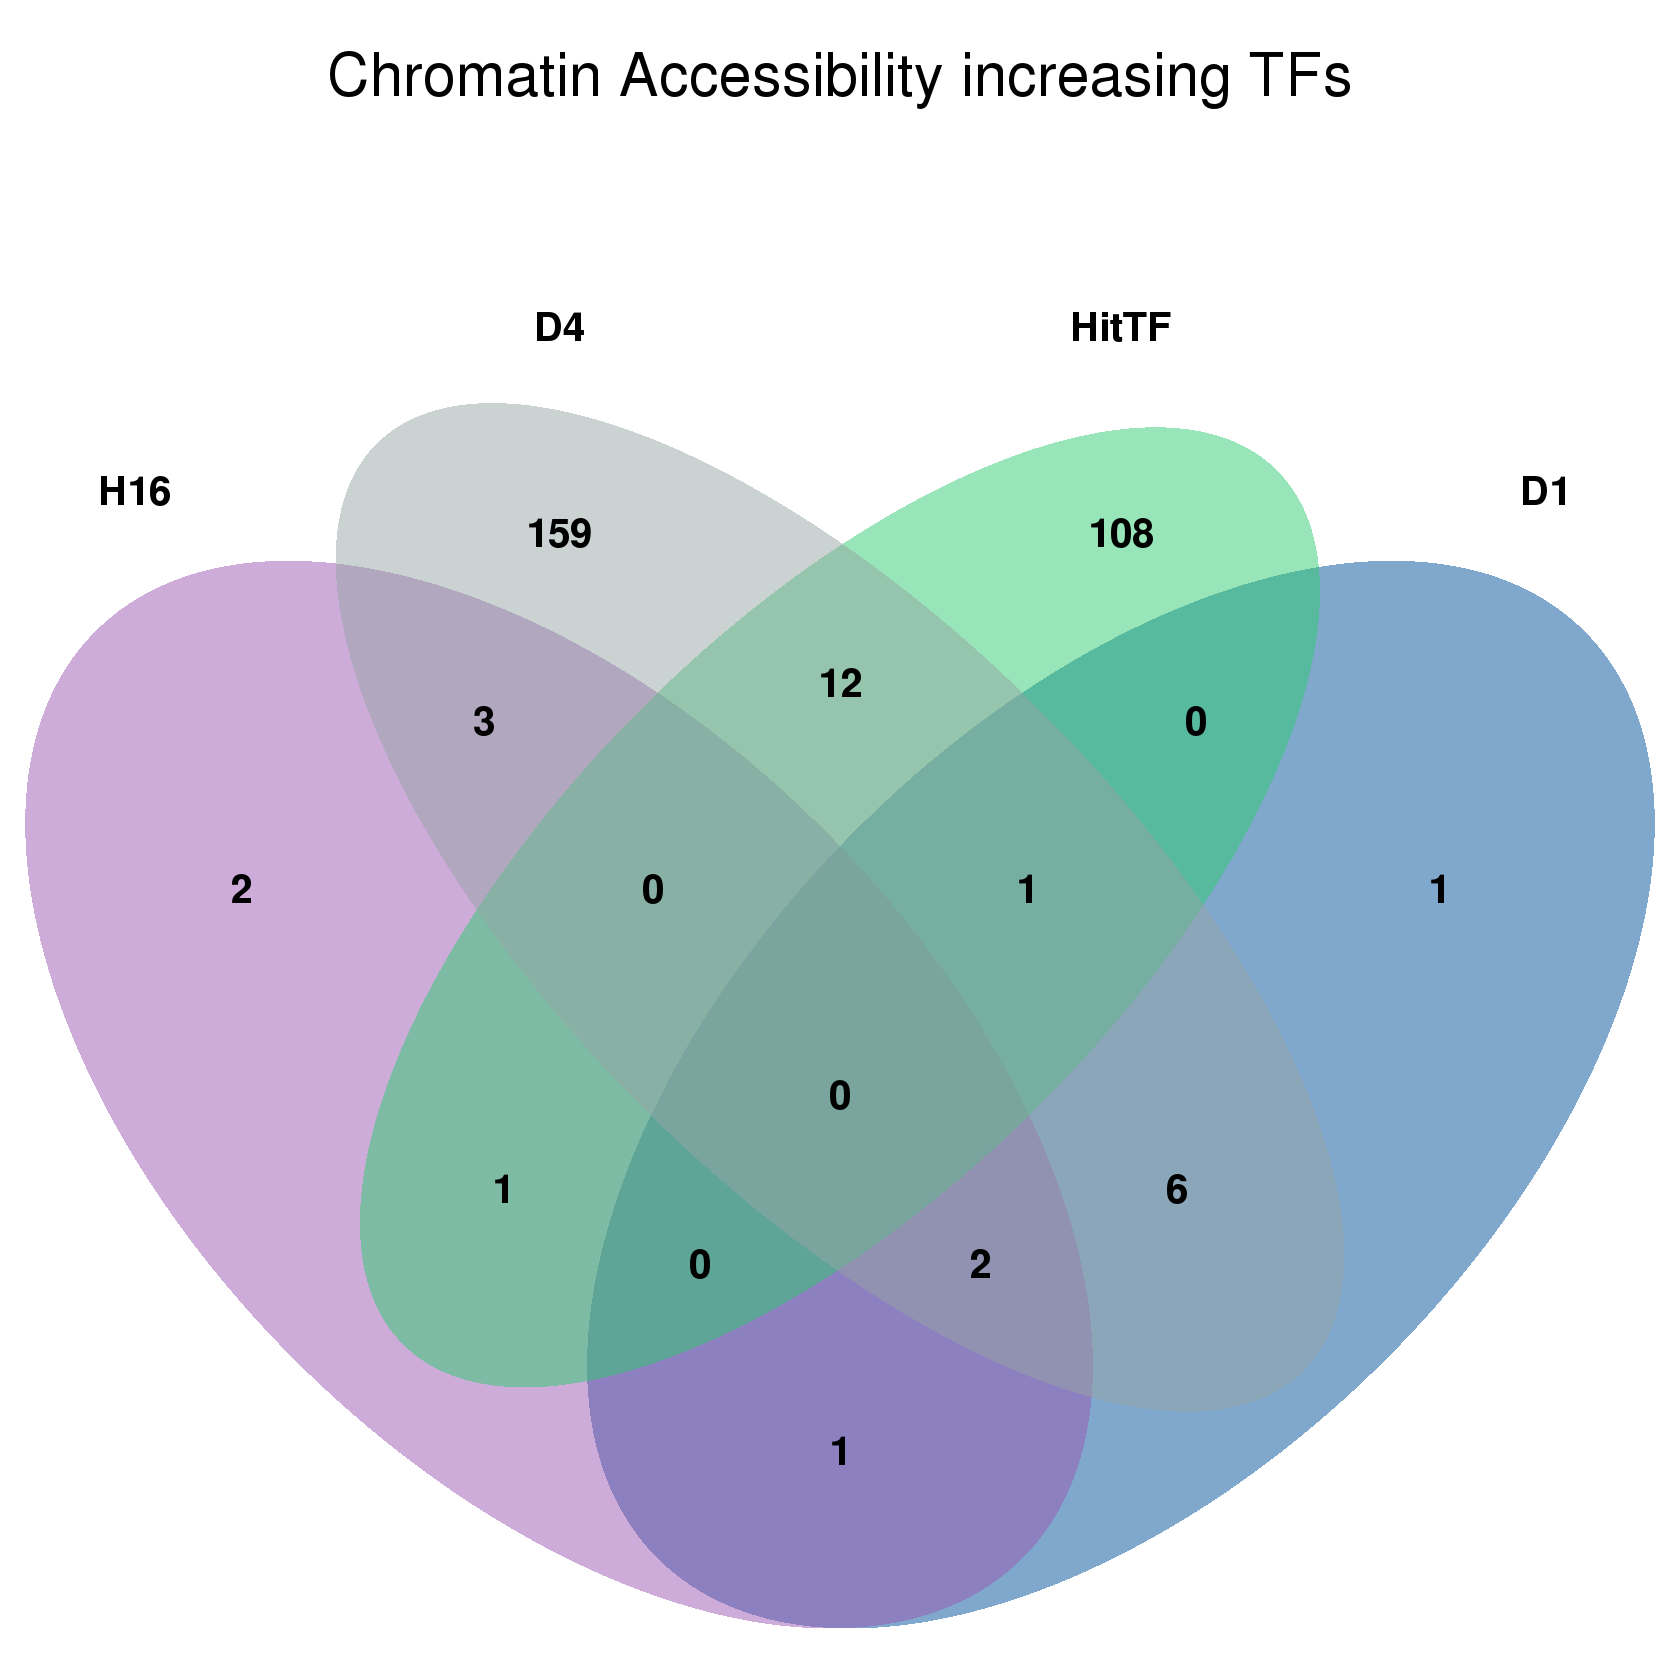

In [659]:
grid.draw(vp)

In [534]:
# differentiated Hit TF
open.hit.tf <- c(H16_vs_ES_up.genes$gene, D1_vs_ES_up.genes$gene, D4_vs_ES_up.genes$gene) %>% unique %>% intersect(., hitlist)

In [516]:
counts(dds2) %>% head
atac_library_totals %>% t

,ATAC1,ATAC2,ATAC3,ATAC4,ATAC5,ATAC6,ATAC7,ATAC8,ATAC9,ATAC10,ATAC11,ATAC12
ABL1,399,334,352,365,425,495,326,515,882,632,600,520
ABT1,201,198,191,151,176,247,142,184,355,234,359,237
ABTB1,396,360,364,373,362,463,238,374,625,439,502,387
ADNP,399,310,380,281,433,470,260,358,701,485,625,603
ADNP2,263,213,213,241,217,315,198,224,385,316,356,348
AEBP1,340,356,270,328,285,377,185,220,470,309,248,197


23580787,21330270,23895858,22991314,21397988,30679291,19704093,21651976,43217344,29385191,22797001,20509473


In [517]:
399 * 1e6 / 23580787

[1] 16.92055

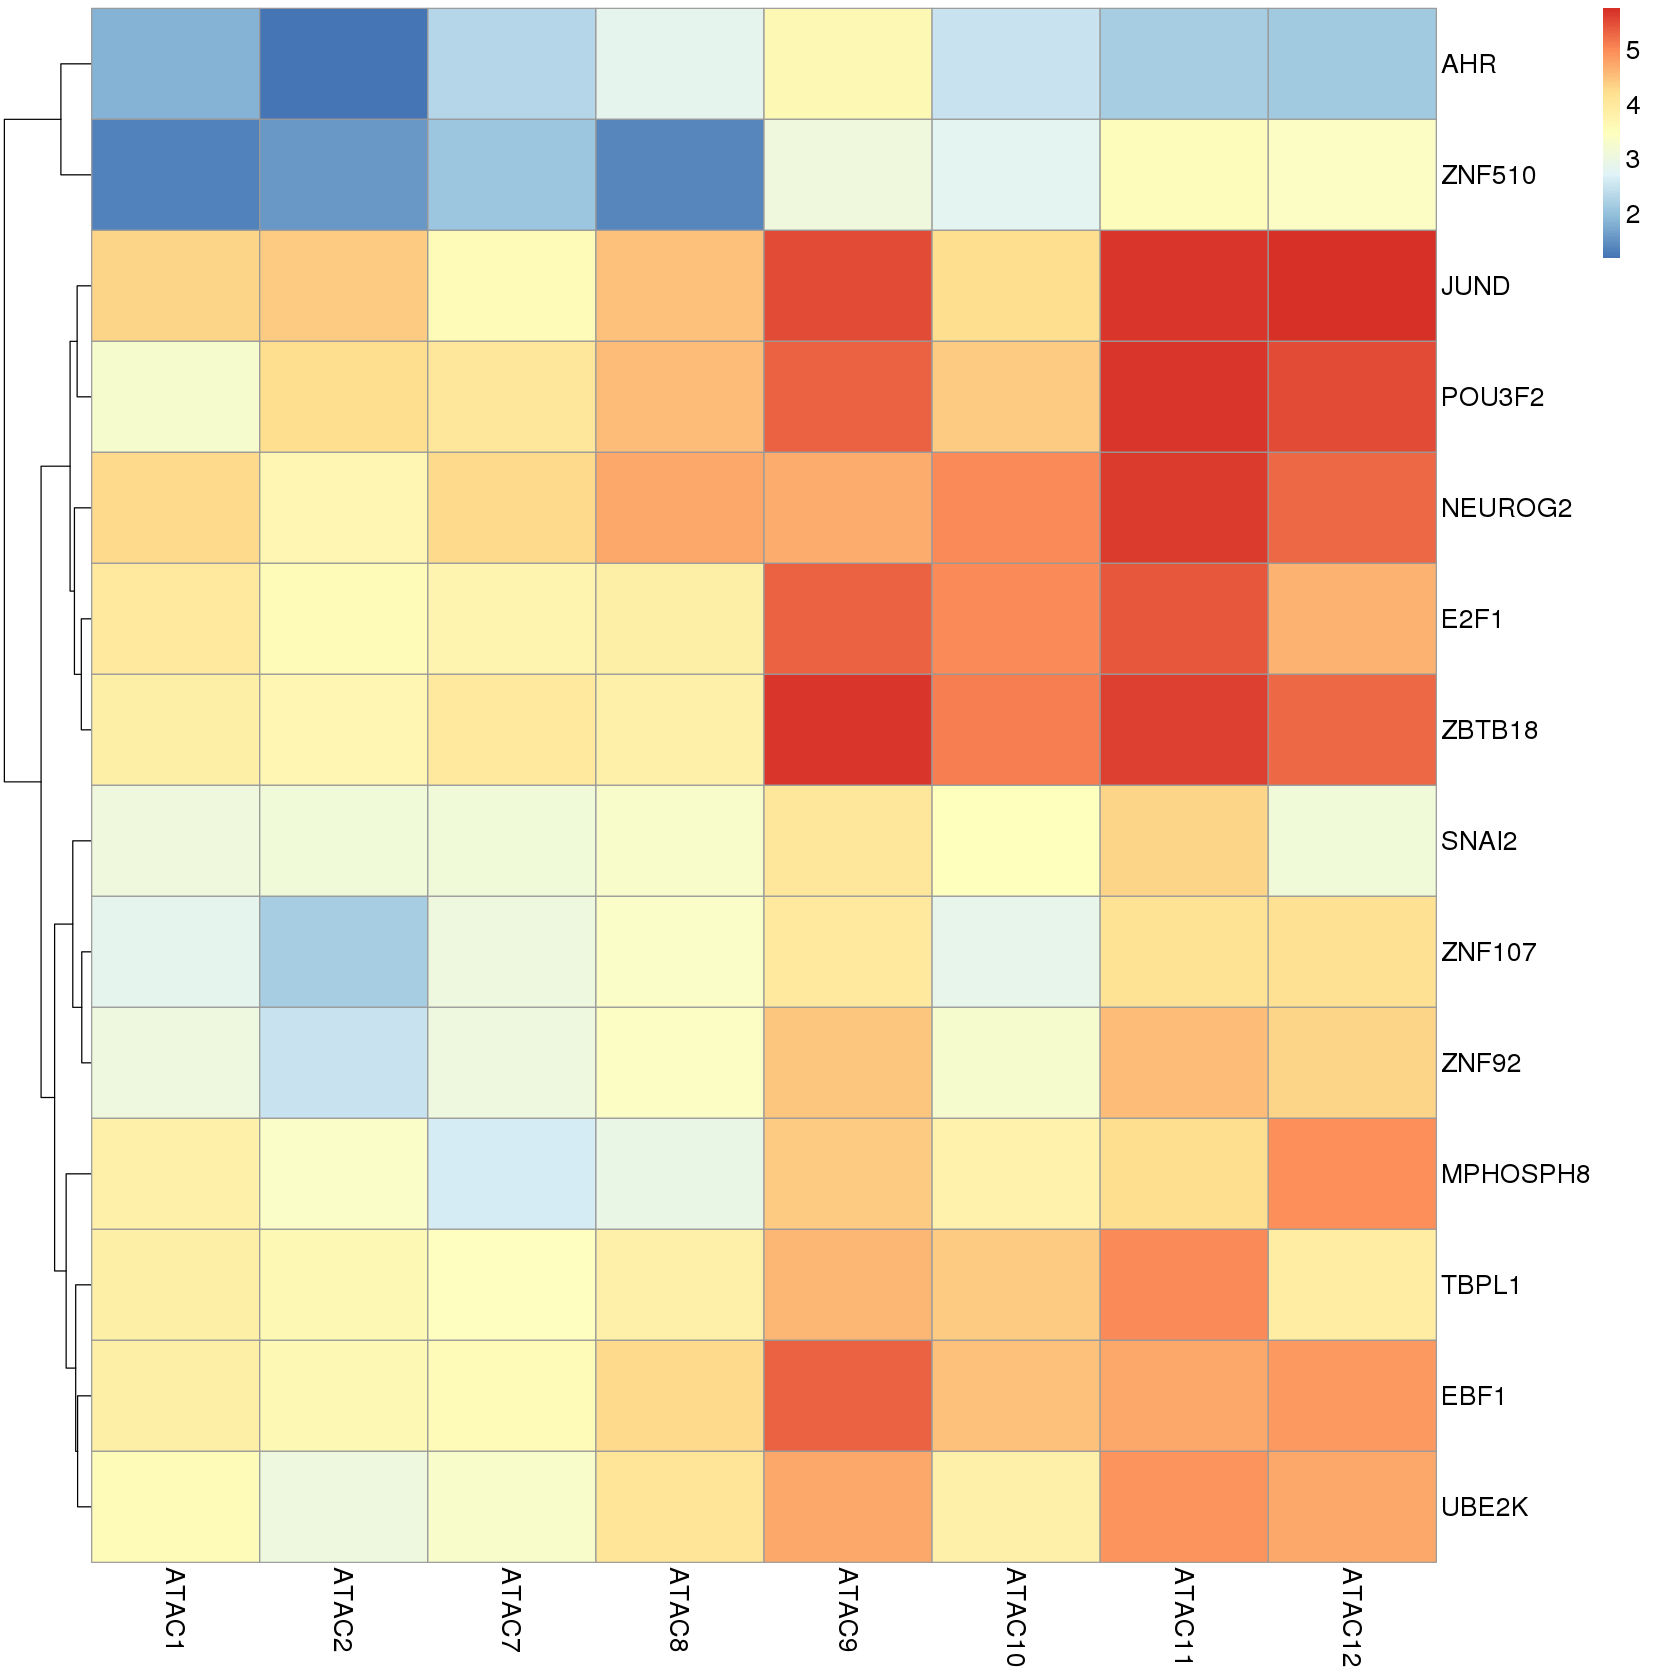

In [617]:
log2(counts(dds2) * 1e6/ atac_library_totals) %>% as.data.frame %>% select(ATAC1:ATAC2, ATAC7:ATAC12) %>% rownames_to_column("gene") %>%
    filter(gene %in% open.hit.tf) %>% column_to_rownames("gene") %>%
    pheatmap(cluster_cols = F, cluster_rows = T, fontsize = 16)

In [668]:
up.hit.tf <- intersect(c(H16_vs_ES_up.genes$gene, D1_vs_ES_up.genes$gene, D4_vs_ES_up.genes$gene), hitlist)
dn.hit.tf <- intersect(c(H16_vs_ES_dn.genes$gene, D1_vs_ES_dn.genes$gene, D4_vs_ES_dn.genes$gene), hitlist)

#### ChromVAR results

In [661]:
suppressMessages(chromvarDF <- read_csv("../chromVAR_jaspar2020_zScore.csv"))

In [664]:
print(up.hit.tf)

 [1] "AHR"      "E2F1"     "EBF1"     "JUND"     "MPHOSPH8" "NEUROG2" 
 [7] "POU3F2"   "SNAI2"    "TBPL1"    "UBE2K"    "ZBTB18"   "ZNF107"  
[13] "ZNF510"   "ZNF92"   


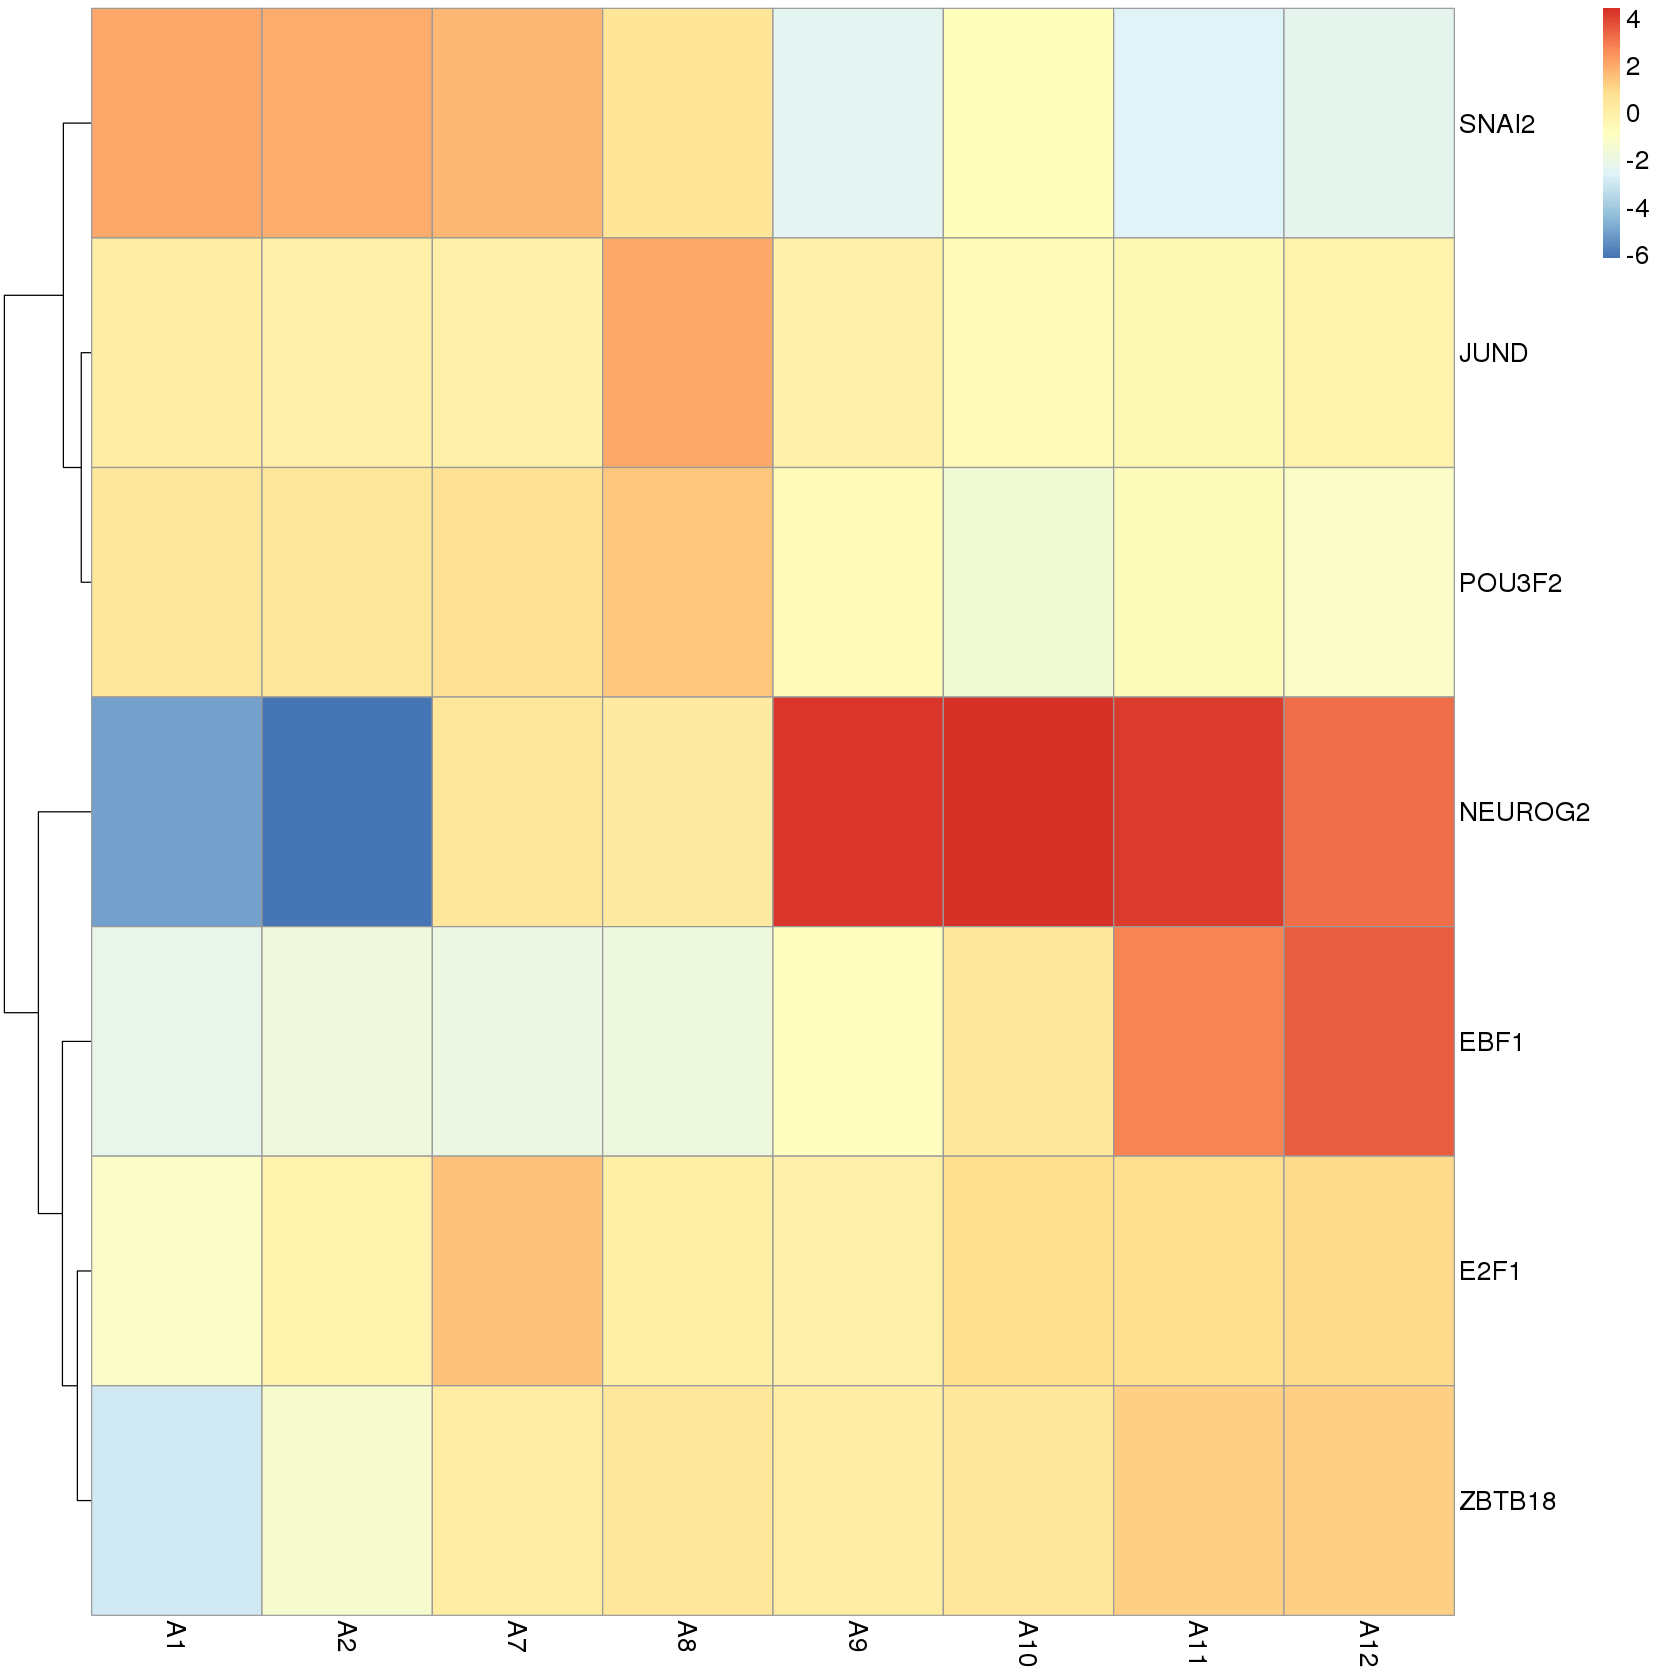

In [663]:
chromvarDF %>% filter(gene_name %in% up.hit.tf) %>% 
    select(gene_name, A1:A2, A7:A12) %>%
    column_to_rownames("gene_name") %>% 
    pheatmap(cluster_cols = F, cluster_rows = T, fontsize = 16)

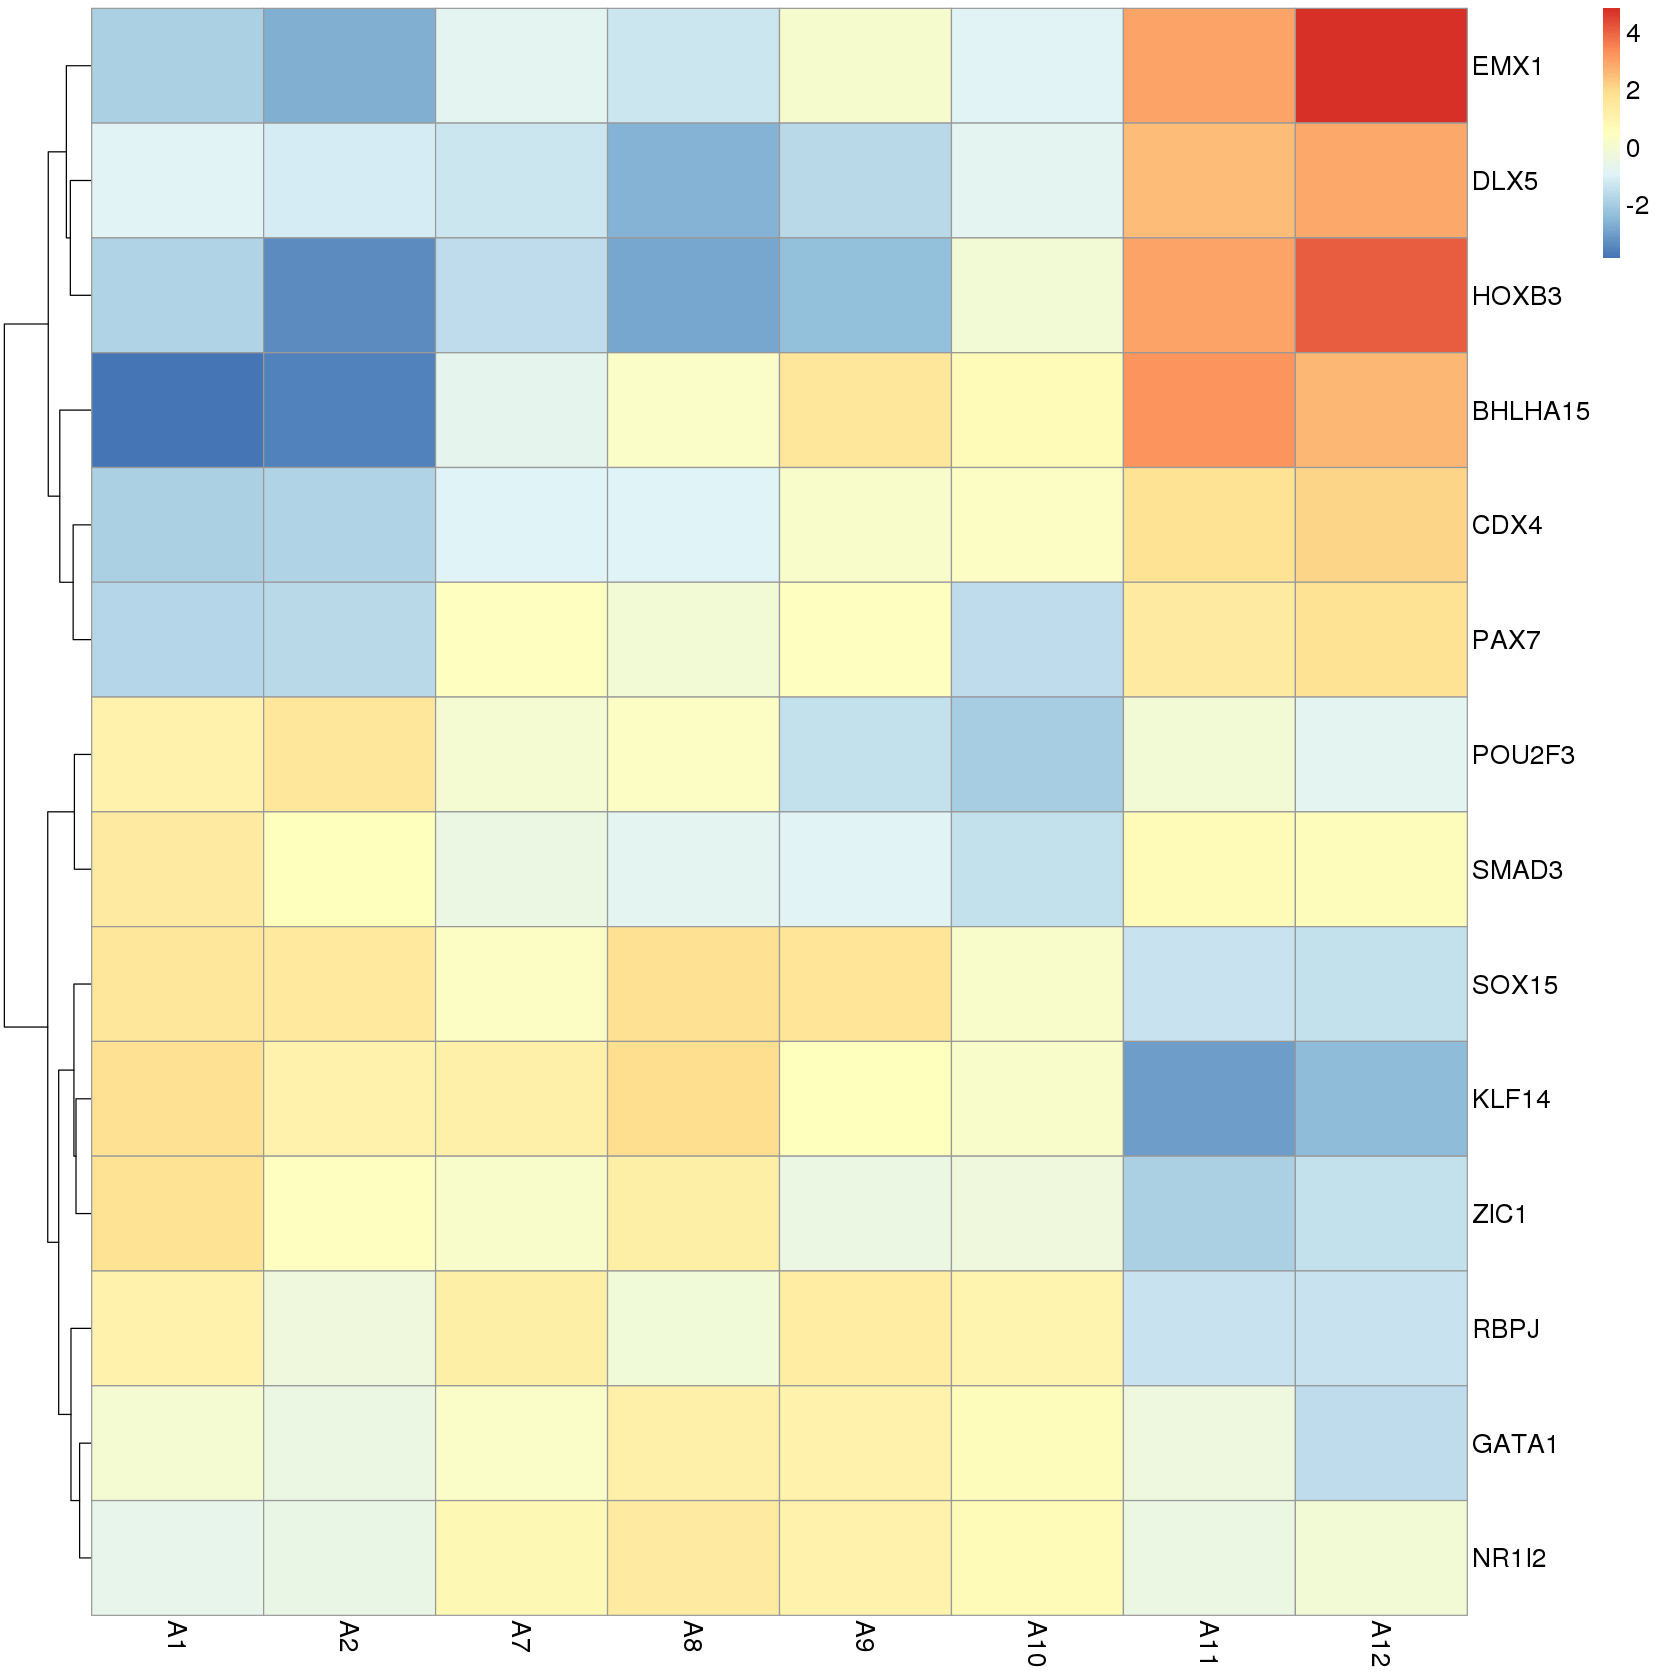

In [670]:
chromvarDF %>% filter(gene_name %in% dn.hit.tf) %>% 
    select(gene_name, A1:A2, A7:A12) %>%
    column_to_rownames("gene_name") %>% 
    pheatmap(cluster_cols = F, cluster_rows = T, fontsize = 16)

#### interactions

In [672]:
getwd()

[1] "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3"

In [673]:
suppressMessages(inter_matrix_unnested <- read_csv("../../Interaction_matrix_nofilter_AllTF_20200107.csv"))

In [674]:
suppressMessages(NGN.started.network.df <- read_csv("../../NGN_started_network_20200107.csv"))

In [675]:
inter2 = left_join(inter_matrix_unnested, NGN.started.network.df[, c(1,2,40)], by = c("regulator_gene", "target_gene")) %>%
            mutate("inNetwork"=if_else(is.na(lev), "not_in_network", "in_network"))

In [680]:
# NEUROG2 targets
filter(inter2, regulator_gene %in% c("NEUROG2") & tar.isHit & target_gene %in% up.hit.tf) %>% 
            select(regulator_gene, target_gene, corr,reg.fdr.H16:reg.fdr.D4, l2fc.H16:fdr.D4)

regulator_gene,target_gene,corr,reg.fdr.H16,reg.fdr.D1,reg.fdr.D4,l2fc.H16,l2fc.D1,l2fc.D4,fdr.H16,fdr.D1,fdr.D4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NEUROG2,AHR,0.8306454,3.985811e-09,7.743982e-12,8.486055e-19,-0.09665570,-0.6904431,-2.1243904,9.793524e-01,6.598332e-01,4.788400e-02
NEUROG2,E2F1,0.5081496,3.985811e-09,7.743982e-12,8.486055e-19,1.20849723,2.1982646,1.2818753,3.506980e-02,1.961639e-06,6.936708e-03
NEUROG2,EBF1,0.9275107,3.985811e-09,7.743982e-12,8.486055e-19,2.51454654,5.0491582,9.7264083,5.891332e-05,5.672568e-22,3.335348e-84
NEUROG2,JUND,0.7108547,3.985811e-09,7.743982e-12,8.486055e-19,-1.20539668,-0.4729756,1.3987611,4.399808e-03,3.820554e-01,9.270377e-05
NEUROG2,POU3F2,0.9936920,3.985811e-09,7.743982e-12,8.486055e-19,6.93958855,8.0227274,11.0584540,7.566588e-14,7.819149e-19,1.483580e-36
NEUROG2,UBE2K,0.6128483,3.985811e-09,7.743982e-12,8.486055e-19,0.09255859,-0.1877083,-0.8616469,8.333022e-01,4.755806e-01,2.113027e-07
NEUROG2,ZBTB18,0.9239091,3.985811e-09,7.743982e-12,8.486055e-19,4.24152864,4.2392123,4.4823694,1.051955e-27,6.274857e-28,1.060066e-31


In [682]:
ngn2.activate <- c("E2F1", "EBF1","JUND","POU3F2", "ZBTB18")

In [684]:
# EBF1 targets
filter(inter2, regulator_gene %in% c("EBF1") & tar.isHit & target_gene %in% up.hit.tf) %>% 
            select(regulator_gene, target_gene, corr,reg.fdr.H16:reg.fdr.D4, l2fc.H16:fdr.D4, reg.l2fc.H16:reg.l2fc.D4)

regulator_gene,target_gene,corr,reg.fdr.H16,reg.fdr.D1,reg.fdr.D4,l2fc.H16,l2fc.D1,l2fc.D4,fdr.H16,fdr.D1,fdr.D4,reg.l2fc.H16,reg.l2fc.D1,reg.l2fc.D4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EBF1,E2F1,0.5081496,5.891332e-05,5.672568e-22,3.335348e-84,1.20849723,2.1982646,1.2818753,3.506980e-02,1.961639e-06,6.936708e-03,2.514547,5.049158,9.726408
EBF1,EBF1,0.9969869,5.891332e-05,5.672568e-22,3.335348e-84,2.51454654,5.0491582,9.7264083,5.891332e-05,5.672568e-22,3.335348e-84,2.514547,5.049158,9.726408
EBF1,JUND,0.7171911,5.891332e-05,5.672568e-22,3.335348e-84,-1.20539668,-0.4729756,1.3987611,4.399808e-03,3.820554e-01,9.270377e-05,2.514547,5.049158,9.726408
EBF1,MPHOSPH8,0.3230130,5.891332e-05,5.672568e-22,3.335348e-84,-0.20052835,0.0951399,0.5777808,8.281197e-01,8.962873e-01,1.685828e-01,2.514547,5.049158,9.726408
EBF1,POU3F2,0.9936920,5.891332e-05,5.672568e-22,3.335348e-84,6.93958855,8.0227274,11.0584540,7.566588e-14,7.819149e-19,1.483580e-36,2.514547,5.049158,9.726408
EBF1,UBE2K,0.6128483,5.891332e-05,5.672568e-22,3.335348e-84,0.09255859,-0.1877083,-0.8616469,8.333022e-01,4.755806e-01,2.113027e-07,2.514547,5.049158,9.726408


In [685]:
ebf1.activate <- c("E2F1","EBF1","JUND", "POU3F2")

In [687]:
#E2F1 targets
filter(inter2, regulator_gene %in% c("E2F1") & tar.isHit & target_gene %in% up.hit.tf) %>% 
            select(regulator_gene, target_gene, corr,reg.fdr.H16:reg.fdr.D4, l2fc.H16:fdr.D4, reg.l2fc.H16:reg.l2fc.D4)

regulator_gene,target_gene,corr,reg.fdr.H16,reg.fdr.D1,reg.fdr.D4,l2fc.H16,l2fc.D1,l2fc.D4,fdr.H16,fdr.D1,fdr.D4,reg.l2fc.H16,reg.l2fc.D1,reg.l2fc.D4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E2F1,E2F1,0.7135162,0.0350698,1.961639e-06,0.006936708,1.2084972,2.1982646,1.2818753,0.0350698,1.961639e-06,0.006936708,1.208497,2.198265,1.281875
E2F1,ZNF510,0.3403975,0.0350698,1.961639e-06,0.006936708,0.4089955,-0.8285654,-0.1695712,0.8157673,4.377418e-01,0.883900791,1.208497,2.198265,1.281875


In [689]:
#ZBTB18 targets
filter(inter2, regulator_gene %in% c("ZBTB18") & tar.isHit & target_gene %in% up.hit.tf) %>% 
            select(regulator_gene, target_gene, corr,reg.fdr.H16:reg.fdr.D4, l2fc.H16:fdr.D4, reg.l2fc.H16:reg.l2fc.D4)

regulator_gene,target_gene,corr,reg.fdr.H16,reg.fdr.D1,reg.fdr.D4,l2fc.H16,l2fc.D1,l2fc.D4,fdr.H16,fdr.D1,fdr.D4,reg.l2fc.H16,reg.l2fc.D1,reg.l2fc.D4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZBTB18,AHR,0.8295724,1.051955e-27,6.274857e-28,1.060066e-31,-0.0966557,-0.6904431,-2.124390,9.793524e-01,6.598332e-01,4.788400e-02,4.241529,4.239212,4.482369
ZBTB18,EBF1,0.8347327,1.051955e-27,6.274857e-28,1.060066e-31,2.5145465,5.0491582,9.726408,5.891332e-05,5.672568e-22,3.335348e-84,4.241529,4.239212,4.482369
ZBTB18,JUND,0.9192697,1.051955e-27,6.274857e-28,1.060066e-31,-1.2053967,-0.4729756,1.398761,4.399808e-03,3.820554e-01,9.270377e-05,4.241529,4.239212,4.482369
ZBTB18,SNAI2,0.3483144,1.051955e-27,6.274857e-28,1.060066e-31,7.7239589,6.6174871,5.303025,8.645019e-30,5.316203e-22,1.300285e-14,4.241529,4.239212,4.482369
ZBTB18,ZBTB18,0.9236994,1.051955e-27,6.274857e-28,1.060066e-31,4.2415286,4.2392123,4.482369,1.051955e-27,6.274857e-28,1.060066e-31,4.241529,4.239212,4.482369
ZBTB18,ZNF107,-0.9537128,1.051955e-27,6.274857e-28,1.060066e-31,-0.1283977,0.4658635,-1.501118,9.298029e-01,4.932331e-01,7.976281e-04,4.241529,4.239212,4.482369


In [690]:
zbtb18.activate <- c("EBF1", "JUND", "SNAI2", "ZBTB18")

In [695]:
c(ngn2.activate, ebf1.activate, zbtb18.activate) %>% unique %>% print

[1] "E2F1"   "EBF1"   "JUND"   "POU3F2" "ZBTB18" "SNAI2" 


In [657]:
vp <- venn.diagram(list("H16"=H16_vs_ES_up.genes$gene, "D1"=D1_vs_ES_up.genes$gene, "D4"=D4_vs_ES_up.genes$gene, "HitTF"=hitlist), 
                   filename=NULL,
                    # Circles
                    lwd = 2,
                    lty = 'blank',
                    fill = flatui[c(1,3,5,9)],
                    main = "Chromatin Accessibility increasing TFs",
                    main.fontfamily = "sans",
                    main.cex = 3,

                    # Numbers
                    cex = 2,
                    fontface = "bold",
                    fontfamily = "sans",

                    # Set names
                    cat.cex = 2,
                    cat.fontface = "bold",
                    cat.default.pos = "outer",
                    #cat.pos = c(-27, 27, 135),
                    #cat.dist = c(0.055, 0.055, .055),
                    cat.fontfamily = "sans")

In [700]:
rnaDF <- readxl::read_excel("../../FoldChangeByTimePoints.xlsx") %>% mutate_at(c("1D", "2D", ))

In [701]:
dge.H16

gene_id,gene_name,expr.flag,15H,1D,2D,4D,7D
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000008083.14,JARID2,23,-1.54740725163679,NA,-2.4582201667002899,-2.30281319155092,-1.3778167768177401
ENSG00000008311.15,AASS,23,-1.3439207116176399,NA,-3.3852320043743598,-3.9526639755605202,-4.3179475548434301
ENSG00000010810.17,FYN,23,2.01232405145839,NA,1.8919113170153801,2.16345796393305,2.72999288171036
ENSG00000017483.15,SLC38A5,16,2.8027908161246202,NA,NA,NA,NA
ENSG00000019549.13,SNAI2,16,6.7804197613191599,NA,NA,NA,NA
ENSG00000047648.23,ARHGAP6,23,6.8538182128312402,NA,7.39172981624061,6.5567722174642604,6.7339710797166603
ENSG00000050344.9,NFE2L3,16,-2.36025639582257,NA,NA,NA,NA
ENSG00000053438.11,NNAT,31,3.8419945547026702,4.3978007135973298,6.1536761676609597,6.4145773318283297,5.5860812785398597
ENSG00000061337.15,LZTS1,31,2.9635159565806899,2.6707641389238201,3.3410825329309199,3.8068378492933399,4.3039391896479797
